In [37]:
import sys
import os
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np

# Add the parent directory to the Python path
sys.path.append(os.path.join(os.path.dirname(os.getcwd())))
# Now you can use absolute imports
from src.utils.data_processing import preprocess_data
from src.utils.defaults import DEFAULTS, DIAMETER_DICT, THICKNESS_DICT, FLOWRATE_DICT, TEMPERATURE_DICT
from src.models.single_pressure.variable_diffusivity_fvt.plotting import (
    plot_diffusivity_profile,
    plot_diffusivity_location_profile,
    plot_norm_flux_over_tau,
    plot_norm_flux_over_time
)

In [24]:
experiment = 'S4R6'
data_path = Path.cwd().parent / 'data' / 'multi_pressure' / f'{experiment}.xlsx'
exp_data = pd.read_excel(data_path)
processed_data = preprocess_data(
    data=exp_data, 
    temperature= TEMPERATURE_DICT[experiment],
    thickness= THICKNESS_DICT[experiment], 
    flowrate= FLOWRATE_DICT[experiment],
    diameter= DIAMETER_DICT[experiment]
    )

In [25]:
processed_data.to_csv(Path.cwd().parent / 'data' / 'multi_pressure' / f'{experiment}_processed.csv', index=False)

In [47]:
from scipy.integrate import solve_ivp

def _solve_pde(previous_D1_prime, D1_prime, DT_0, T, X, L, dx, 
                D2_prime=1.0, rel_tol=1e-8, atol=None,
                dt_init=0.0005, track_solving_progress=True,
                D0=None):  # Removed unused parameters
    # Discretize space
    Nx = int(X / dx) + 1
    x = np.linspace(0, X, Nx)
    K = DT_0 / (L * L)
    
    # Define the ODE system derived from Method of Lines
    def diffusion_ode(t, D):
        """Convert PDE to system of ODEs using Method of Lines"""
        dDdt = np.zeros_like(D)
        dx2 = dx * dx
        
        # Apply interior points dynamics
        for i in range(1, len(D)-1):
            lapl = (D[i+1] - 2.0*D[i] + D[i-1]) / dx2
            dDdt[i] = K * D[i] * lapl
        
        # Boundary conditions
        dDdt[0] = 0  # Fixed D1_prime (Dirichlet)
        dDdt[-1] = 0  # Fixed D2_prime (Dirichlet)
        
        return dDdt
    
    # Initial condition
    if D0 is None:
        # D0 = np.ones(Nx, dtype=np.float64)
        #* Use linear space for initial condition
        D0 = np.linspace(previous_D1_prime, D2_prime, Nx, dtype=np.float64)
        
        D0[0] = D1_prime     # Left boundary
        D0[-1] = D2_prime    # Right boundary
    else:
        # Ensure boundary conditions are properly set in provided D0
        D0[0] = D1_prime
        D0[-1] = D2_prime
    
    # Configuration for the solver
    if atol is None:
        atol = rel_tol * 0.1  # Set absolute tolerance based on relative tolerance
    
    # Track solution timing if progress tracking is enabled
    if track_solving_progress:
        start_time = time.time()
        print(f"Starting solve_ivp integration (D1'={D1_prime:.2f}, DT0={DT_0:.2e})...")
        
    # Solve using solve_ivp with BDF method (good for stiff problems)
    solution = solve_ivp(
        diffusion_ode, 
        t_span=[0, T],
        y0=D0,
        method='BDF',  # Backward Differentiation Formula (for stiff problems)
        rtol=rel_tol,
        atol=atol,
        first_step=dt_init,  # Initial step hint
        max_step=T/10,  # Use reasonable max step based on total time
        dense_output=True  # Allow interpolation for output
    )
    
    if track_solving_progress:
        end_time = time.time()
        solve_time = end_time - start_time
        print(f"Integration complete. Time taken: {solve_time:.4f} seconds")
        print(f"Number of function evaluations: {solution.nfev}")
        print(f"Number of Jacobian evaluations: {solution.njev}")
        print(f"Solver status: {solution.status} (0=success)")
    
    # Extract solution information - get more points for smoother output
    num_output_points = min(1000, max(100, int(T/10)))  # Adaptive number of output points
    t_eval = np.linspace(0, T, num_output_points)
    D_history = []
    
    for t in t_eval:
        D_t = solution.sol(t)
        D_history.append(D_t)
    
    D_arr = np.array(D_history)
    
    # Calculate normalized flux
    F_norm = (-(D_arr[:, -1] - D_arr[:, -2]) / dx) / (-(D2_prime - D1_prime) / X)
    
    # Create DataFrames for output
    Dprime_df = pd.DataFrame(D_arr, columns=[f"x={xi:.3f}" for xi in x], index=t_eval)
    flux_df = pd.DataFrame({
        "time": t_eval,
        "normalised_flux": F_norm,
        "tau": DT_0 * t_eval / (L * L)
    })
    
    return Dprime_df, flux_df



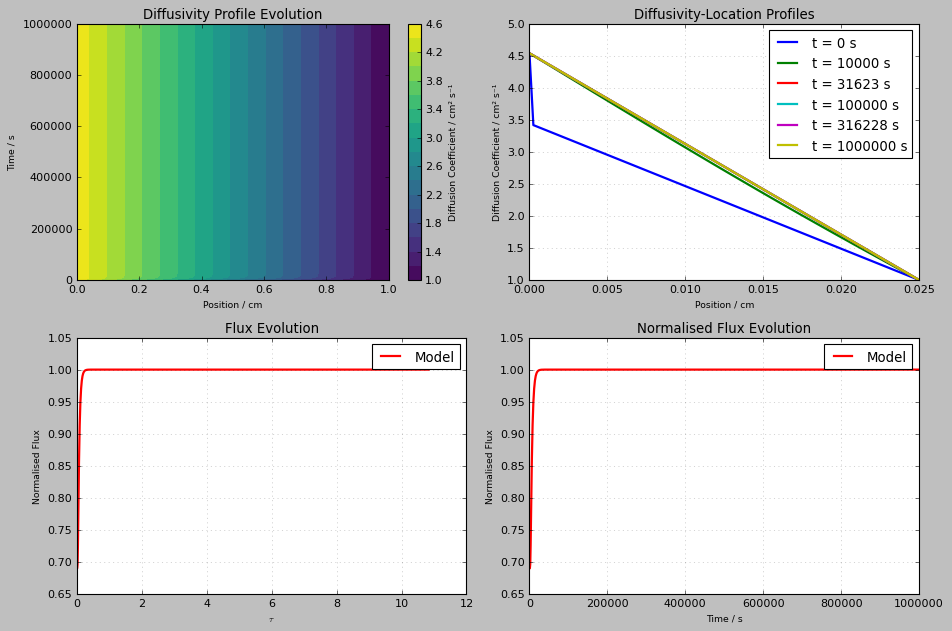

In [48]:
thickness = THICKNESS_DICT[experiment]
T = 1e6 # [s]

# Solver with solve_ivp
Dprime_df, flux_df = _solve_pde(
    previous_D1_prime=3.4406,
    D1_prime=4.537,
    DT_0=6.77e-9,
    T=T,
    X=1.0,
    L=THICKNESS_DICT[experiment],
    dx=0.01,
    dt_init=0.001,
    rel_tol=1e-8,
    atol=None,
    track_solving_progress=False
)

# Create plots
figures = {}

# Create figure with subplots
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12, 8))    # 2x2 plot

# Plot concentration profile evolution
plot_diffusivity_profile(
    diffusivity_profile=Dprime_df,
    ax=ax1,
    display=False
)

# Plot concentration-location profiles
plot_diffusivity_location_profile(
    diffusivity_profile=Dprime_df,
    L=thickness,
    T=T,
    ax=ax2,
    display=False
)

# Plot flux evolution
plot_norm_flux_over_tau(
    flux_data=flux_df,
    # experimental_data=experimental_data,
    ax=ax3,
    display=False
)

plot_norm_flux_over_time(
    flux_data=flux_df,
    # experimental_data=experimental_data,
    ax=ax4,
    display=False
)

plt.tight_layout()
plt.show()

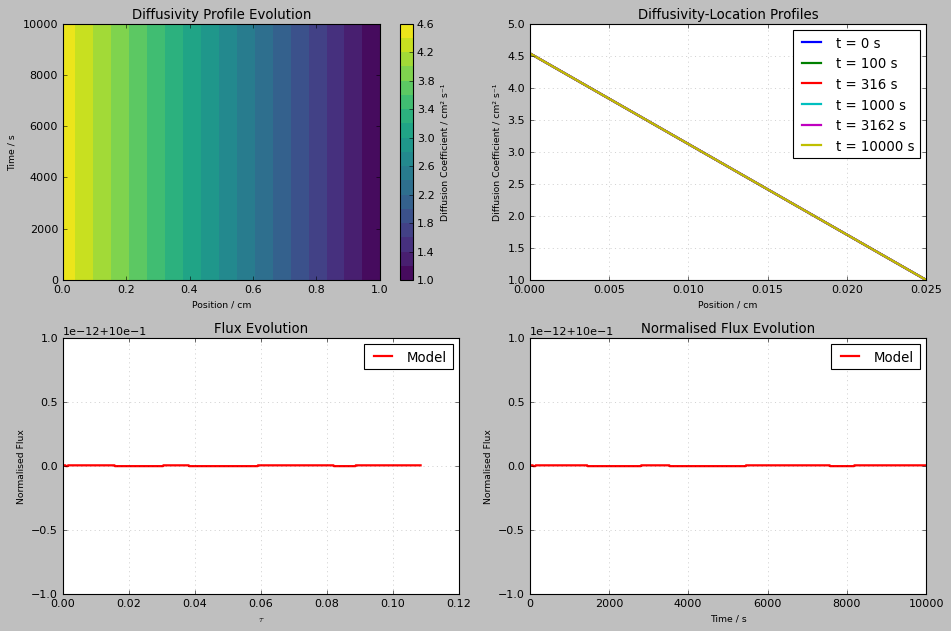